# Day26 Category Overlay

Build a consistent overlay for per-category plots generated during the Day26 smoothing experiments.

This notebook discovers every `cat_*` directory inside the configured figure parent directory, locates the requested plot type for each category, and stitches the individual PNGs into a grid (default 3 columns). Update the configuration cell below when a different moving average, plot type, or parent path is needed.

In [ ]:
from pathlib import Path
from math import ceil
from typing import List, Sequence, Tuple

from PIL import Image
import matplotlib.pyplot as plt

PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_CAE_detrend_gaussian_CAE')
# PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_CAE_detrend_moving_average_CAE')
# PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_gaussian_rho')
# PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho')
#MOVAVG_WINDOW = 'movavg_5p00'
MOVAVG_WINDOW = 'guass_5p00'
PLOT_SUFFIX = 'rho_progression'
CATEGORY_PREFIX = 'cat_'
NUM_COLUMNS = 3
OUTPUT_FILENAME = f"{MOVAVG_WINDOW}_{PLOT_SUFFIX}_overlay.png"
SUBJECT_OVERRIDE = None
STORY_OVERRIDE = None


def infer_subject_story(parent_dir: Path) -> Tuple[str, str]:
    try:
        idx = parent_dir.parts.index('figs')
    except ValueError as exc:
        raise ValueError("Unable to locate 'figs' in the parent directory path.") from exc
    try:
        return parent_dir.parts[idx + 1], parent_dir.parts[idx + 2]
    except IndexError as exc:
        raise ValueError("Parent directory must include subject and story segments after 'figs'.") from exc


subject, story = infer_subject_story(PARENT_DIR)
if SUBJECT_OVERRIDE:
    subject = SUBJECT_OVERRIDE
if STORY_OVERRIDE:
    story = STORY_OVERRIDE

print(f'Parent directory: {PARENT_DIR}')
print(f'Subject/story: {subject}/{story}')
print(f'Moving average window: {MOVAVG_WINDOW}')
print(f'Plot suffix: {PLOT_SUFFIX}')

Parent directory: /flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho
Subject/story: UTS01/wheretheressmoke
Moving average window: none_0p00
Plot suffix: rho_progression


In [2]:
def resolve_story_dirs(base_dir: Path, story: str) -> List[Path]:
    if not base_dir.exists():
        return []
    direct = base_dir / story
    if direct.is_dir():
        return [direct]
    dirs = [path for path in sorted(base_dir.iterdir()) if path.is_dir()]
    matches = [
        path for path in dirs
        if path.name.startswith(f"{story}_") or path.name.startswith(f"{story}-")
    ]
    if matches:
        return matches
    matches = [path for path in dirs if story in path.name]
    if matches:
        return matches
    if len(dirs) == 1:
        return dirs
    return []


def collect_category_images(parent_dir: Path, movavg_window: str, plot_suffix: str,
                              category_prefix: str, subject: str, story: str) -> Tuple[Sequence[Tuple[str, Path]], Sequence[Path]]:
    discovered = []
    missing = []
    for category_dir in sorted(parent_dir.iterdir()):
        if not category_dir.is_dir() or not category_dir.name.startswith(category_prefix):
            continue
        category_label = category_dir.name.rstrip('_')
        subject_dir = category_dir / movavg_window / subject
        story_dirs = resolve_story_dirs(subject_dir, story)
        image_path = None
        for story_dir in story_dirs:
            candidate = (story_dir / 'day22_category_mde' / 'plots' / category_label /
                         f'mde_{category_label}_{plot_suffix}.png')
            if candidate.exists():
                image_path = candidate
                break
        if image_path is None:
            fallback_story_dir = story_dirs[0] if story_dirs else subject_dir / story
            missing.append(
                fallback_story_dir / 'day22_category_mde' / 'plots' / category_label /
                f'mde_{category_label}_{plot_suffix}.png'
            )
            continue
        discovered.append((category_label, image_path))
    return discovered, missing


category_images, missing_images = collect_category_images(
    PARENT_DIR,
    MOVAVG_WINDOW,
    PLOT_SUFFIX,
    CATEGORY_PREFIX,
    subject,
    story,
)

print(f'Located {len(category_images)} plot(s).')
if missing_images:
    print('Missing the following plot files:')
    for path in missing_images:
        print(f'  - {path}')
else:
    print('All expected plots were found.')

category_images


Located 12 plot(s).
All expected plots were found.


[('cat_abstract',
  PosixPath('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho/cat_abstract_/none_0p00/UTS01/wheretheressmoke/day22_category_mde/plots/cat_abstract/mde_cat_abstract_rho_progression.png')),
 ('cat_communal',
  PosixPath('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho/cat_communal_/none_0p00/UTS01/wheretheressmoke/day22_category_mde/plots/cat_communal/mde_cat_communal_rho_progression.png')),
 ('cat_emotional',
  PosixPath('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho/cat_emotional_/none_0p00/UTS01/wheretheressmoke/day22_category_mde/plots/cat_emotional/mde_cat_emotional_rho_progression.png')),
 ('cat_locational',
  PosixPath('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho/cat_location

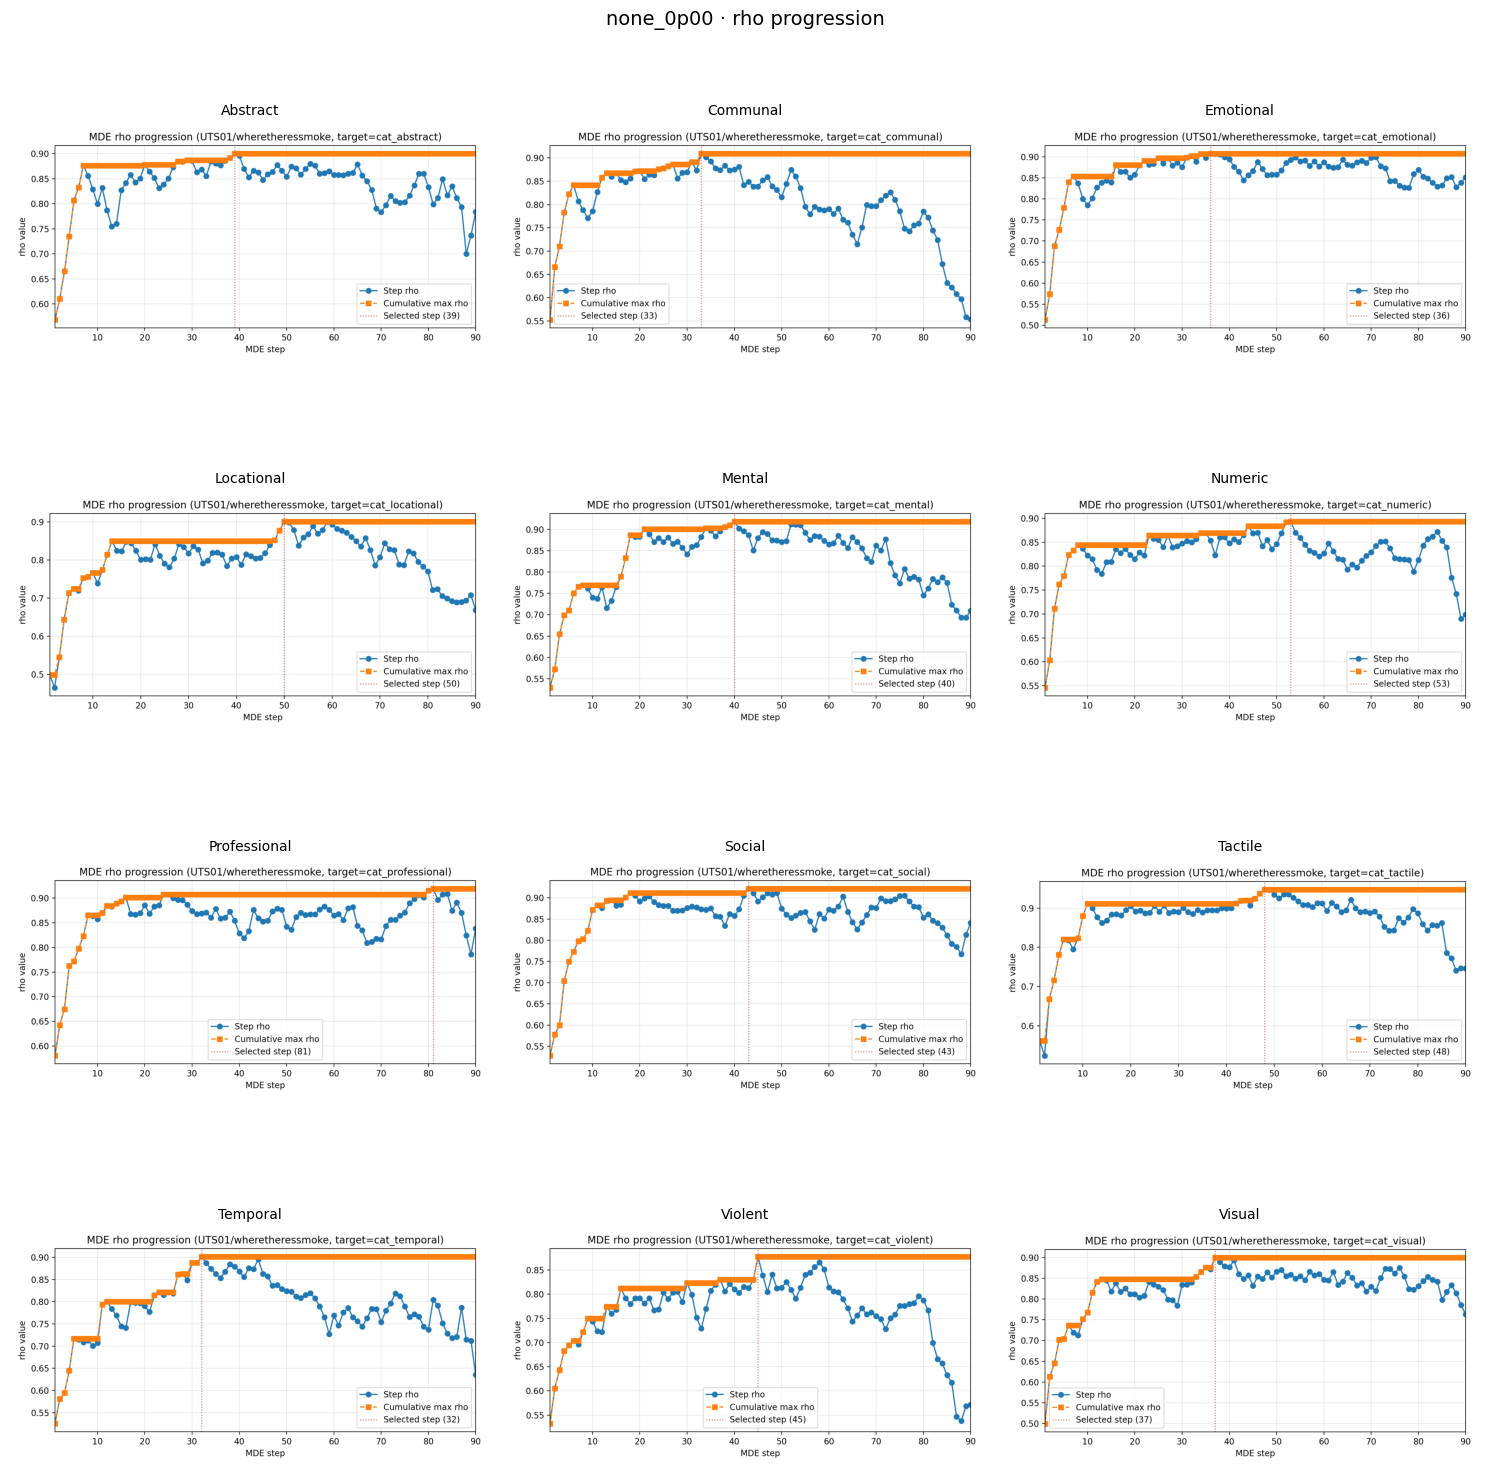

In [3]:
if not category_images:
    raise ValueError('No category plots were located; adjust your configuration and re-run the previous cell.')

num_rows = ceil(len(category_images) / NUM_COLUMNS)
fig, axes = plt.subplots(num_rows, NUM_COLUMNS, figsize=(NUM_COLUMNS * 5, num_rows * 4), squeeze=False)
axes_iter = axes.flatten()

for ax in axes_iter:
    ax.axis('off')

for ax, (category_label, image_path) in zip(axes_iter, category_images):
    with Image.open(image_path) as img:
        ax.imshow(img)
    pretty_label = category_label.replace('cat_', '').replace('_', ' ').title()
    ax.set_title(pretty_label, fontsize=10)

fig.suptitle(f"{MOVAVG_WINDOW} · {PLOT_SUFFIX.replace('_', ' ')}", fontsize=14)
overlay_fig = fig
plt.tight_layout()
plt.show()

In [4]:
output_path = PARENT_DIR / OUTPUT_FILENAME
if 'overlay_fig' not in globals():
    raise NameError('Run the plotting cell before attempting to save the overlay figure.')

overlay_fig.savefig(output_path, dpi=200, bbox_inches='tight')
print(f'Saved overlay to: {output_path}')

Saved overlay to: /flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho/none_0p00_rho_progression_overlay.png
